#### Simultaneous Stellar Parameters / Photometry Fitting

the basic goals is to create a function call to Parsec isochrones
that takes as input a set of physical parameters, age $\tau$, metallicity MH, and (initial) stellar mass, $M_*$ and return observables such as $T_{eff}$, log$g$, and absolute magnitudes M$_\lambda$.

The first implementation is to just load in a large set of Padova isochrones, and simply make a nearest neighbour call. This has limitations, but isochrone "interpolation" is a known rabbit hole

### settled and open issues  (of this version v7, Sep 1, 2023)

* code has been re-written (mostly the "function calls) to now not find the best fit isochrone point, but to collect all the "good" (in a chi2 sense) isochrone points, and calculate the np.exp(-chi2) weighted mean of the "physical isochrone parameters" MH,logAge,Mini,Av and return them for each object along with their uncertainties.

* we need to understand which pieces of the data "dominate" the fit, the G-band magnitudes?  The path forward here is to look at the difference between the "data" and the "best fit isochrones". E.g. the metallicities often get shifted around a lot.


* do we need to re-weigh spectroscopy and photometry?

* do we need to consider a finer grid of extinctions?

* NOTE: I put some double checking notes in the function call that filters out the right isochrones...


### next steps

* when calling "get_means_and_covariances" should we make an analogous call to get us the weighted mean predictions for th isochrone-predicted observables (magnitudes, Teff, etc..); at the moment we only get the best value..

* split the file in an auxiliary and a main part? Is that useful?

* identify points that have unusual D$\chi^2$ weights, and understand why they got selected. This may require getting the a set of chi2s returned, all that are within XXX of the minimum.

* understand whether we should create a much finer grid of extinctions, but only select the ones where the observed colors are consistent with Teff and th eexpected reddening range.

* fit spectroscopic data only?


set up packages ...

In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import time
import timeit


from astropy.io import fits as fits

from astropy.table import Table,vstack, hstack,Column
from astropy.io import ascii
from astropy.io.votable import parse_single_table


from matplotlib.colors import LogNorm
import scipy.stats as stats

import astropy.table as at
from astropy.coordinates import SkyCoord
from astropy import units as u

from pyia import GaiaData

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sys

from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

#### read in pre-downloaded isochrones; this version switches to the finer grid from Povick. But note, we need to subsample

In [2]:
workdir = '/Users/rix/Science/Projects/GAIA/GaiaDR3/BP-RP/LMC/'

In [3]:
# from povick
isochrone = 'parsec36_Povick_sparsed.fits'
isochrone = 'parsec36_Povick_sparsed_young_added.fits'
iso = at.Table.read(workdir+isochrone)


In [4]:
### it annoys HWR, so logT --> Teff
# ... i.e. switch to linear temperatures
iso['logTe'] = 10.** iso['logTe'] 
iso.rename_column('logTe', 'Teff')

This table has 704283  rows at present


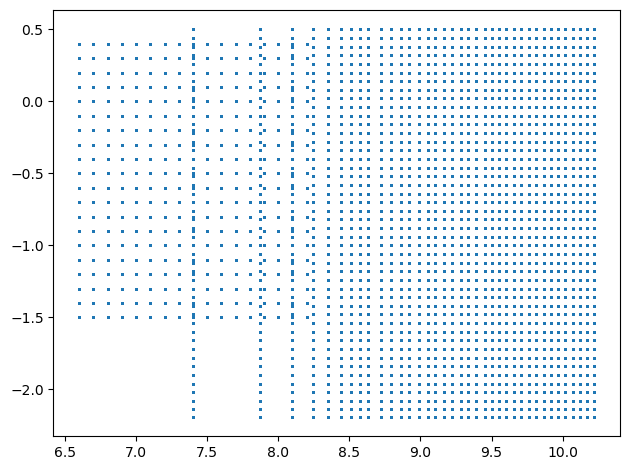

In [5]:
print('This table has',len(iso),' rows at present')
plt.scatter(iso['logAge'],iso['MH'],s=1)
plt.show()

### What's in the table?

In [6]:
print('the table has the following columns: ',iso.columns)
#and how many rows does it have
print(' there are a total of ',len(iso),' rows')
#print('the data types are',iso[:].dtype)

the table has the following columns:  <TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','Teff','logg','label','McoreTP','Jmag','Hmag','Ksmag','Gmag','G_BPmag','G_RPmag')>
 there are a total of  704283  rows


In [7]:
print(iso[3])

   Zini    MH   logAge      Mini         int_IMF        Mass  logL        Teff         logg label McoreTP  Jmag Hmag       Ksmag        Gmag  G_BPmag G_RPmag
--------- ---- -------- ----------- ------------------ ----- ----- ------------------ ----- ----- ------- ----- ---- ----------------- ------ ------- -------
0.0060543 -0.4 10.17173 0.136330694 1.4183171987999998 0.136 -2.72 2989.5099278145867 5.146     1     0.0 9.551 9.01 8.767000000000001 12.748  14.637   11.46


###   we now calculate the "weights" (or probability) of each isochrone point
* we presume that the probability is uniforem with respect to (logAge) and MH
* we will implement the IMF probability, presuming a kroupa IMF
* the most important part is the $\frac{dM_{init}}{d{\mathrm \ grid\  point}}$, which is calculated in the step below
* in the end we will add $-2\times ln(p_{grid})$ to the $\chi^2$ of each grid point, given a data point

##### first auxiliary step: define a Kroupa normalized MF

In [8]:
def kroupa_imf(m, m_min=0.01, m_max=100, m1=0.08, m2=0.5, alpha1=0.3,alpha2=1.3,alpha3=2.3):
    
    # Calculate normalization constants for each segment to ensure continuity
    A1 = (alpha2 - alpha1) / (m1**(alpha2 - alpha1) - m_min**(alpha2 - alpha1))
    A2 = A1 * m1**(alpha2 - alpha1)
    A3 = A2 * m2**(alpha3 - alpha2)
    
    # Calculate the contributions to the normalization factor from each segment
    norm1 = A1 / (1 - alpha1) * (m1**(1 - alpha1) - m_min**(1 - alpha1))
    norm2 = A2 / (1 - alpha2) * (m2**(1 - alpha2) - m1**(1 - alpha2))
    norm3 = A3 / (1 - alpha3) * (m_max**(1 - alpha3) - m2**(1 - alpha3))
    
    # Calculate the total normalization factor
    norm_factor = norm1 + norm2 + norm3
    
    # Define the IMF
    if m < m1:
        return A1 * m**(-alpha1) / norm_factor
    elif m1 <= m < m2:
        return A2 * m**(-alpha2) / norm_factor
    else:
        return A3 * m**(-alpha3) / norm_factor

#### Now, take add the two components of the weighting, the intrinsic speed of the isochrone evolution at that point, and the IMF probability of having a star at that mass

In [9]:
# first calculate the probability of mass "Mini" given a Kroupa IMF
kroupa_probability = [kroupa_imf(m) for m in iso['Mini']]

# Create a new column 'DMini' filled with zeros initially
iso['DMini'] = 1.e-14

# Loop through the rows of the table from the second row to the second-last row
for i in range(1, len(iso) - 1):
    if iso['Mini'][i + 1] > iso['Mini'][i] and iso['Mini'][i - 1] < iso['Mini'][i]:
        iso['DMini'][i] = 0.5 * (iso['Mini'][i + 1] - iso['Mini'][i - 1])
    else:
        iso['DMini'][i] = 1.e-14
        
# this is a crucial step. It calculates the prior probability of each isochrone point
iso['Dchi2_corr'] = -2*np.log(iso['DMini']) - 2*np.log(kroupa_probability)

#print(iso['Dchi2_corr'])

### Create dust-reddened versions of the isochrone predictions

##### Why?
In the end, we want to find the isochrone points that best fit the data, both the spectroscopic parameters and the photometry. For a given set of spectroscopic parameters, the reddening changes the photometry

##### Why so early in the code?

-- we have to do it only once

-- we want to index the final rows of the isochrone table at the start for 

#### What needs to be done?

1) We define the reddening vector RV and an array of Av values.

2) We add a zero-Av column to the original table iso.

3) We initialize an empty list all_tables to store the original and modified tables.

4) A for-loop iterates over each Av value. Inside the loop, we create a modified version of iso_pred by adding Av * RV to the columns 'G_BPmag','Gmag','G_RPmag','Jmag','Hmag','Ksmag'.
####!!! the column names are hardwired at the moment !!!

5) We add a new 'Av' column to the modified table with the applied Av value.

6) Finally, we vertically stack all the tables together to create iso_pred_ext, which contains the original and modified versions of iso_pred.

In [10]:
# these are RV valies for BP,G,RP,J,H,K from Cardelli (via Povick)
RV = np.array([1.21821835, 1., 0.77005965, 0.34260963, 0.21702019, 0.13758333])
# this sets the reddening grid, and needs to be re-considered
Av = np.array([0., 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.2, 1.6, 2.1])
## temp for the large table
#Av = np.array([0., 0.06, 0.1, 0.15, 0.2,  0.3,  0.5, 0.9])

# Add a zero-Av column to the original table
iso['Av'] = np.zeros(len(iso))

# Initialize list to store modified tables
all_tables = [iso]

# Loop over each Av value to create modified tables
for av in Av[1:]:  # Skip the first value (0) as the original table already covers it
    mod_table = iso.copy()  # Make a copy of the original table
    ### column names hardwired here !!!
    for i, col_name in enumerate(['G_BPmag','Gmag','G_RPmag','Jmag','Hmag','Ksmag']):
        mod_table[col_name] += av * RV[i]  # Apply the reddening
    mod_table['Av'] = np.full(len(mod_table), av)  # Fill the 'Av' column with the current Av value
    all_tables.append(mod_table)

# Combine all tables
iso_Av = vstack(all_tables)

In [11]:
print('the table has the following columns: ',iso_Av.columns)
#and how many rows does it have
print(' there are a total of ',len(iso_Av),' rows')
#print('the data types are',iso[:].dtype)

the table has the following columns:  <TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','Teff','logg','label','McoreTP','Jmag','Hmag','Ksmag','Gmag','G_BPmag','G_RPmag','DMini','Dchi2_corr','Av')>
 there are a total of  11268528  rows


Let's make a plot to verify that the addition of reddening worked

In [12]:
#Teff = iso_Av['Teff']
#cc = iso_Av['Jmag']-iso_Av['Ksmag']
#plt.scatter(Teff,cc,s=1,c=iso_Av['Av'])
#plt.ylim(-0.5,5.5)
#plt.xlim(3500.,17500.)
#plt.colorbar(label='A_V')
#plt.gca().invert_xaxis()
#plt.show()

#### add a column that is the row index. We will need that for book-keeping later

In [13]:
iso_Av['index'] = np.arange(len(iso_Av))

Now split the isochrone table into two parts:

-- the first contains the physical input parameters: metallicity, age and initial mass

-- the second contains the corresponding spectroscopic and photometric parameters

In [14]:
iso_in = iso_Av['MH', 'logAge','Mini','Av','Dchi2_corr','index']

### the full array of observables would look like this
#temp = iso['logL','logTe','logg','Gmag','G_BPmag','G_RPmag',
#                          'Jmag','Hmag','Ksmag','W1mag','W2mag']
# for the time being, we use only
iso_pred = iso_Av['Teff','logg','MH','Gmag','G_BPmag','G_RPmag',
                          'Jmag','Hmag','Ksmag','index']
print(' there are a total of ',len(iso_pred),' rows')
#print('the data types are',iso[:].dtype)

 there are a total of  11268528  rows


### necessary function definitions

#### we start out with the summary function that takes the observation array, and returns the chi2 and indices of all pertinent isochrone entries


1) first pull out the (small?) subset of all isochrine points that is within +- 0.5 mag of the observed K-magnitude

2) turn table (sans 'index' column) into an array

3) calculate the (one data point's) chi2 for ALL isochrone points that surved the cut

4) return the chi2 s and the (initial) indices, that tells you what age,M/H and M* they came from

#### then we define a function call that selects from the whole isochrone table those rows whose Ksmag agrees (withon 0.3mag) with that of the object we are trying to fit.

In [15]:
def filter_table(obs,stddev,iso_pred):
    # now set some preconditions to discard all isochrone points that will miss
    # basic observables by more than, say, 7 sigma.
    start_wall2 = time.time()
    nsig = 5
    Teff,dTn = obs[0],nsig * stddev[0]
    dTeff = dTn if 50 <= dTn <= 200 else min(max(dTn, 50), 200)
    MH,dMH = obs[2],nsig * stddev[2]
    dMH = dMH if 0.1 <= dMH <= 0.5 else min(max(dMH, 0.1), 0.5)
    Gmag,dGn = obs[3],nsig * stddev[3]
    dGmag = dGn if 0.04 <= dGn <= 0.3 else min(max(dGn, 0.04), 0.3)
    Ksmag,dKn = obs[7],nsig * stddev[7]
    dm = dKn if 0.06 <= dKn <= 0.3 else min(max(dKn, 0.06), 0.3)
    #print(Teff,stddev[0],dTeff, Gmag, stddev[3],dGmag,Ksmag, stddev[7], dm)
    #input("Press Enter to continue...")
    # Filter rows where 'Ksmag' < 0
    filtered_rows = iso_pred[ 
                            (iso_pred['Ksmag']<Ksmag+dm) * (iso_pred['Ksmag']>Ksmag-dm)*
                            (iso_pred['Teff']<Teff+dTeff) * (iso_pred['Teff']>Teff-dTeff)*
                            (iso_pred['MH']<MH+dMH) * (iso_pred['MH']>MH-dMH)*
                            (iso_pred['Gmag']<Gmag+dGmag) * (iso_pred['Gmag']>Gmag-dGmag)
                            ]
    
    if len(filtered_rows) > 10:
        #print(len(filtered_rows),' which took', 1000.*(time.time()-start_wall2),' milliseconds')
        # Create a new table with all columns except 'index'
        return filtered_rows[[col for col in iso_pred.colnames if col != 'index']],filtered_rows['index']
    else:
        #print('found no nearby isochrone points; retaining full isochrone')
        return iso_pred[[col for col in iso_pred.colnames if col != 'index']],iso_pred['index']
        
    

In [16]:
def chi2_for_one_object(obs,stddev,isochrones):
    # we start by pearing out the (snmall) subset of isochrones that has the right Ksmag, which obs[7]
    subset,indices = filter_table(obs,stddev,isochrones)
    # now turn the subset into an 2D array, and check that its dimensions are compatible with the observations
    subset_array = np.array([subset[col] for col in subset.columns]).T
    #print(subset_array.shape,obs.shape,variance.shape)
    return compute_chi2(obs, stddev**2, subset_array),indices
    

this call draws on 

In [17]:
def compute_chi2(data, variances, model):
    # Make sure dimensions match
    if data.shape[0] != variances.shape[0]:
        raise ValueError("Data and variances must have the same length")
        
    if model.shape[1] != data.shape[0]:
        raise ValueError("Number of columns in model must match length of data")
        
    # Reshape data and variances to enable broadcasting in NumPy
    data = data.reshape(1, -1)
    variances = variances.reshape(1, -1)
    
    # Compute the chi2 values
    diff = data - model  # shape will be (K, N)
    chi2_values = np.sum((diff ** 2) / variances, axis=1)
    chi2_values[chi2_values <= 0] = 1.e-6
    
    return chi2_values

#### and one more set of function calls, whose purpose it is to take -- for a given object -- als the isochrone points with a chi2 not too much worse (Dchi2_lim) than the chi2 minimum, and calculate age, M/H etc.. statistic from it.

* the first one  returns the indices of all the elements in the chi2 array
t

In [18]:
def find_indices_within_chi2_limit(chi2s, Dchi2_lim):
    min_value = chi2s[np.argmin(chi2s)]
    within_limit_indices = np.where(np.abs(chi2s - min_value) <= Dchi2_lim)[0]
    return within_limit_indices

def get_means_and_covariances(chi2s, iso_in):
    # Calculate the weights based on chi2s
    weights = np.exp(-chi2s)
    
    # Normalize the weights
    sum_weights = np.sum(weights)
    normalized_weights = weights / sum_weights
    
    # List of columns
    columns = ['MH', 'logAge', 'Mini', 'Av']
    
    # Initialize lists to hold means
    means = []
    
    # Loop through each column to calculate weighted mean
    for column in columns:
        # Calculate the weighted mean
        weighted_mean = np.sum(iso_in[column] * normalized_weights)
        means.append(weighted_mean)
        
    # Initialize covariance matrix
    covariance_matrix = np.zeros((4, 4))
    
    # Loop through each pair of columns to calculate the covariance
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            deviations1 = iso_in[col1] - means[i]
            deviations2 = iso_in[col2] - means[j]
            
            covariance_matrix[i, j] = np.sum(normalized_weights * deviations1 * deviations2)
            
    # Convert list to numpy array for returning
    means = np.array(means)
    
    return means, covariance_matrix







#### Now comes the grand chi2 call
This takes a 1D array "data", where entries constitute N attributes of a given object. The function also accepts a 1D array "variances" that has the same shape, but where the entries reflects the variance in the estimate  of each "data" attribute. In addition, this function also accepts a 2D array "model" that has shape K x N, i.e. K rows and the same number of columns as the dimension of "data". For each row k=1,K the function than calculates the chi2 of Sum_1^N (data-model)^2/variances^2, and returns a 1D array of chi2 that has length K.

Here the "data" are the observables of one object, from Teff to Ksmag; here of length 7. The "variances" are their uncertainties; and K are the possible isochrone prodictions, each of length 7.

In [19]:
def stellar_params(obs_table,std_table,ids,iso_pred,iso_in,nupdate):
    Dchi2_lim = 7.    # this is the chi2 limit (among isochgrone points)
                      #around the best value where we calculate statistics
    # convert table to numpy arrays here
    obs = np.vstack([obs_table[col].data for col in obs_table.columns])
    std = np.vstack([std_table[col].data for col in std_table.columns])
    
    # now set up the structure for what he fit returns
    indx_best = []
    chi2_best = []
    fit_results = Table(
    names=('fitMH', 'fitlogAge', 'fitMini', 'fitAv', 'varMH', 'varlogAge', 'varMini', 'varAv', 'covariances'),
    dtype=('f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'O'))

    start_wall = time.time()
    for i in range(obs.shape[1]):
        chi2s,indx = chi2_for_one_object(obs[:,i],std[:,i],iso_pred)
                
        # now do the "gridpoint probability" correction to chi2
        chi2s = chi2s + iso_in['Dchi2_corr'][indx]

        # now select all the isochrone points with "pretty good" chi2
        indx_good = find_indices_within_chi2_limit(chi2s, Dchi2_lim)
        #print(chi2s[indx_good],iso_pred['Gmag'][indx[indx_good]])
        #input("Press Enter to continue...")
        
        #plt.scatter(iso_pred['Teff'][indx[indx_good]],iso_pred['Gmag'][indx[indx_good]])
        #plt.show()
        means,covariance_matrix = get_means_and_covariances(chi2s[indx_good],iso_in[indx[indx_good]])
        uncertainties = np.sqrt(np.diag(covariance_matrix))
    

        # Append a new row to the fit_results table
        fit_results.add_row([means[0], means[1], means[2], means[3],
                     uncertainties[0], uncertainties[1], uncertainties[2], uncertainties[3],
                     covariance_matrix])
        # check...
        #print(fit_results[-1])
        #input("Press Enter to continue...")
        
        #mean_values,covariance_matrix = get_means_and_covariances(chi2s[indx_good],iso_in[indx[indx_good]])
        #uncertainties = np.sqrt(np.diag(covariance_matrix))
        #print(mean_values)
        #C

         
        #ibest = indx[np.argmin(chi2s)]
        chi2_best.append(np.argmin(chi2s))
        indx_best.append(indx[np.argmin(chi2s)])
        
        
        #print(iso_in[indx[np.argmin(chi2s)]])
        #print(np.min(chi2s))
        if (i % nupdate)== 0:
            if (i >0):
                print('Have done',i,'stars so far. This took',time.time()-start_wall,' seconds')
                #print('mean values for this objects are:',means,uncertainties) #,iso_pred[indx[np.argmin(chi2s)]])
                
                interim_table = hstack([ids[:i],obs_table[:i],fit_results,iso_in[indx_best[:i]],iso_pred[indx_best[:i]]])
                columns_to_keep = [name for name in interim_table.colnames if name != 'covariances']
                new_table = interim_table[columns_to_keep]
                new_table.write(workdir+'interim_table.fits', format='fits',overwrite=True)
                #input("Press Enter to continue...")
    end_wall = time.time()
    print('The age/mass estimate for these',obs.shape[1],' objects took ',
          int((end_wall - start_wall)),' seconds ')
    
    
    # now put together a table to return
    iso_in_sub = iso_in[indx_best]
    iso_pred_sub = iso_pred[indx_best]
    if 'index' in iso_pred_sub.colnames:
        iso_pred_sub.remove_column('index')
        iso_pred_sub.remove_column('MH')
        
    # make sure the best-fit chi2 can be added
    chi2obs_column = Column(data=chi2_best, name='chi2obs')
    obs_table.add_column(chi2obs_column)
    #print('iso_pred check',iso_pred_sub.colnames)
    # make sure that all tables have the same number of rows
    assert len(iso_in_sub) == len(iso_pred_sub) == len(obs_table) == len(ids) == len(chi2_best) == len(fit_results)
    # Horizontally stack the tables
    combined_table = hstack([ids,obs_table,fit_results,iso_in_sub,iso_pred_sub])
    #return iso_in[indx_best]
    return combined_table
    

    
        
        

## Now we try  out things

### We'll load in Josh's test data from the LMC

... and convert the to "absolute magnitude" by subtracting a universal distance modulus of 18.5

... and separate the "observables" from the "standard deviations" and dump all this into numpy arrays (probably shouldn't have)

.... note, rows with NaNs get eliminated; this may need attention

In [38]:
#pick the right data table: just RGB stars, or all?
#lmc = Table(fits.getdata(workdir+'lmc_data_rgb.fits')) 
lmc = Table(fits.getdata(workdir+'lmc_data_allXPStars.fits')) 

#N = 900  # Replace with the actual number of rows you want
#lmc = lmc[:N]

#Remove rows containing NaNs
mask = np.all(~np.isnan(lmc.to_pandas().values), axis=1)
lmc = lmc[mask]

print(lmc.columns) 

# columns to be converted to "absolute magnitude"
cols_to_modify = ['BP', 'G', 'RP', 'J', 'H', 'K']
# using the distance modulus of 
DM = 18.5

# Modify the specified columns
for col in cols_to_modify:
    lmc[col] = lmc[col] - DM
    
print('Well, thats  ', len(lmc), ' sources!!')

<TableColumns names=('source_id','BP','G','RP','BP_ERR','G_ERR','RP_ERR','ALPHA_FE','ALPHA_FE_ERR','DISTANCE','J','H','K','J_ERR','H_ERR','K_ERR','TEFF','TEFF_ERR','TEFF_XP','TEFF_XP_ERR','LOGG','LOGG_ERR','FE_H','FE_H_ERR')>
Well, thats   654220  sources!!


#### setting a floor to the photometric uncertainties
* and also set a floor to logg

In [39]:
# now set floors that can be different for the different bands; the order is
#.    'Jmag', 'Hmag', 'Ksmag', 'Gmag', 'G_BPmag', 'G_RPmag', 'logg'
dmin_array = np.array([0.03, 0.03, 0.03 , 0.03, 0.03, 0.03, 0.1])
# the next line would be 'spectroscopy only'
#dmin_array = np.array([0.6, 0.6, 0.1 , 0.4, 0.4, 0.4, 0.2])

# List of column names to modify
columns_to_modify = ['J_ERR', 'H_ERR', 'K_ERR', 'G_ERR', 'BP_ERR', 'RP_ERR','LOGG']

# Iterate through each column and its corresponding dmin value
for col, dmin_value in zip(columns_to_modify, dmin_array):
    lmc[col][lmc[col] < dmin_value] = dmin_value

#### now split the table into the "observables" and their "uncertainties"; also keep track of the source_ids

In [40]:
lmc_ids = lmc['source_id']
lmc_obs = lmc['TEFF', 'LOGG','FE_H','G','BP','RP','J','H','K']
lmc_std = lmc['TEFF_ERR', 'LOGG_ERR','FE_H_ERR','G_ERR','BP_ERR','RP_ERR','J_ERR','H_ERR','K_ERR']
## do we take the original temperatures??
#lmc_obs = lmc['TEFF_XP', 'LOGG','FE_H','G','BP','RP','J','H','K']
#lmc_std = lmc['TEFF_XP_ERR', 'LOGG_ERR','FE_H_ERR','G_ERR','BP_ERR','RP_ERR','J_ERR','H_ERR','K_ERR']

In [41]:
num_rows = len(lmc_ids)

# Generate 1000 random indices
random_indices = np.random.choice(num_rows, 100000, replace=False)  # replace=False ensures unique indices

# Create a new table containing only the randomly chosen rows
lmc_rids = lmc_ids[random_indices]
lmc_robs = lmc_obs[random_indices]
lmc_rstd = lmc_std[random_indices]

Now define a function that determines the parameters (age,FeH,mass,Av) for a set of stars,
and -- on output -- creates a table that has these parameters added as columns to the initial input table, thereby creating an output table.

In [42]:
age_fits = stellar_params(lmc_obs,lmc_std,lmc_ids,iso_pred,iso_in,10000)
#age_fits = stellar_params(lmc_robs,lmc_rstd,lmc_rids,iso_pred,iso_in,10000)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == "":


Have done 10000 stars so far. This took 569.7149500846863  seconds
Have done 20000 stars so far. This took 1027.9736020565033  seconds
Have done 30000 stars so far. This took 1522.6445722579956  seconds
Have done 40000 stars so far. This took 2099.1639442443848  seconds
Have done 50000 stars so far. This took 2753.8777079582214  seconds
Have done 60000 stars so far. This took 3362.4940111637115  seconds
Have done 70000 stars so far. This took 4244.121393203735  seconds
Have done 80000 stars so far. This took 4982.414785146713  seconds
Have done 90000 stars so far. This took 5618.503988981247  seconds
Have done 100000 stars so far. This took 6529.330339193344  seconds
Have done 110000 stars so far. This took 7135.500419139862  seconds
Have done 120000 stars so far. This took 7722.670826911926  seconds
Have done 130000 stars so far. This took 8187.726360082626  seconds
Have done 140000 stars so far. This took 9061.789712190628  seconds
Have done 150000 stars so far. This took 10236.13707

In [43]:
columns_to_keep = [name for name in age_fits.colnames if name != 'covariances']
new_table = age_fits[columns_to_keep]
print(new_table[2])

     source_id             TEFF        LOGG   FE_H      G          BP         RP      J      H      K   chi2obs        fitMH            fitlogAge          fitMini             fitAv              varMH            varlogAge            varMini              varAv          MH   logAge         Mini         Av     Dchi2_corr      index         Teff        logg  Gmag        G_BPmag             G_RPmag           Jmag            Hmag              Ksmag       
------------------- ----------------- ----- ------- ---------- ---------- --------- ------ ------ ----- ------- ------------------- ----------------- ------------------ ----------------- ------------------- ------------------ ------------------- ------------------- ----- -------- ------------------ --- ------------------ ------- ----------------- ----- ------ ------------------- ------------------- ------------ ------------------ ------------------
4614626215600513792 4216.763370066962 0.905 -1.4449 -2.3632545 -1.5153561 -3.265273 -4.388 -5.

In [44]:
new_table.write(workdir+'age_fitting.Sep3.2023.v1.fits', format='fits',overwrite=True)

In [45]:
age_fits = new_table

In [50]:
#just for plotting, fuzz the ages
fuzz_age = age_fits['logAge']+np.random.normal(0, 0.1, len(age_fits['logAge']))

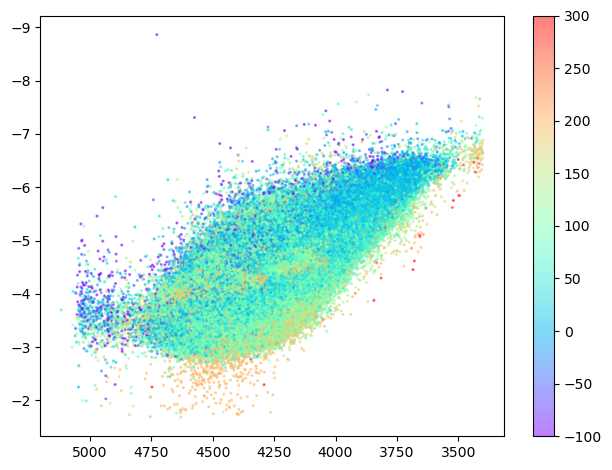

In [195]:
plt.scatter(age_fits['TEFF'],age_fits['K'],
            alpha=0.5,s=1.5,c=age_fits['Teff']-age_fits['TEFF'],vmin=-100,vmax=300.,cmap='rainbow')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
#plt.ylim(-200.,200.)

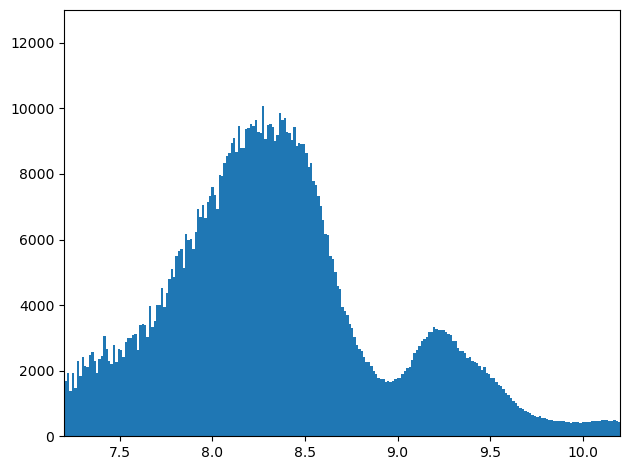

In [51]:
plt.hist(fuzz_age,bins=300,weights=10.**-(fuzz_age-9))
plt.xlim(7.2,10.2)
plt.ylim(0.,13000)
plt.show()

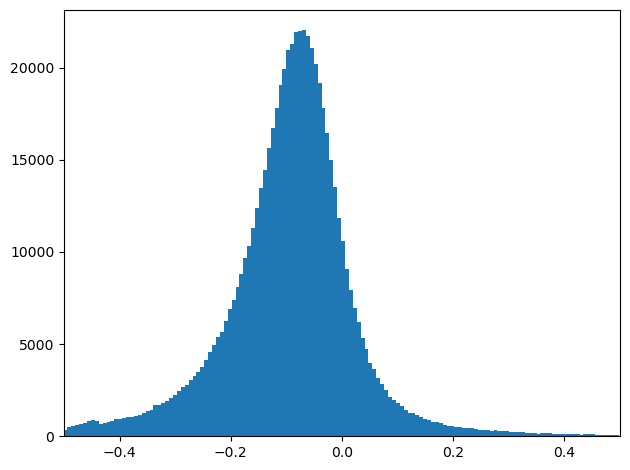

In [52]:
plt.hist(age_fits['FE_H']-age_fits['fitMH'],bins=500)
plt.xlim(-0.5,0.5)
plt.show()

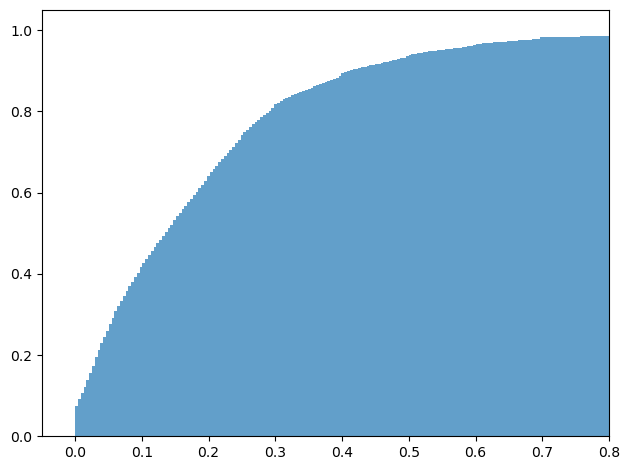

In [55]:

plt.hist(age_fits['fitAv'], bins=500, cumulative=True, density=True, alpha=0.7, label='fitAv')
plt.xlim(-0.05,0.8)
#plt.yscale('log')
plt.show()

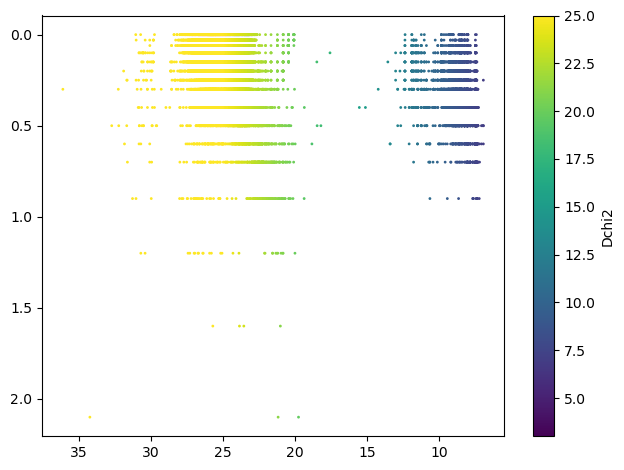

In [125]:
plt.scatter(age_fits['Dchi2_corr'],age_fits['Av'],s=1,c=age_fits['Dchi2_corr'],vmin=3,vmax=25)
#plt.ylim(-7.5,0.5)
#plt.xlim(3500.,5500.)
plt.colorbar(label='Dchi2')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
#plt.show()

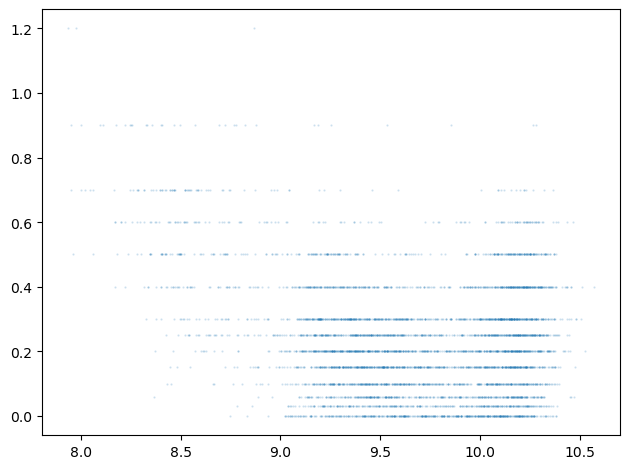

In [106]:
plt.scatter(fuzz_age,age_fits['Av'],alpha=0.2,s=0.3)

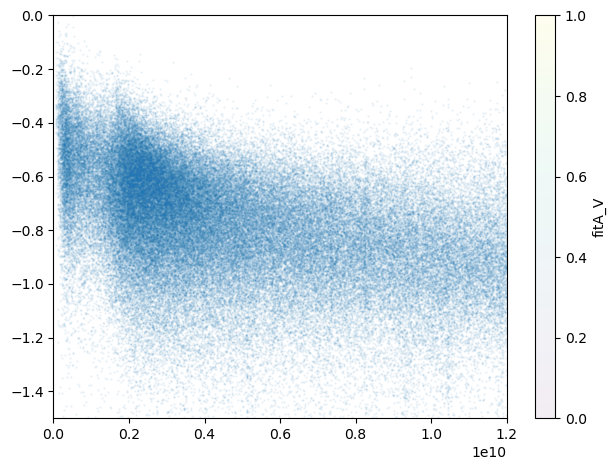

In [75]:
plt.scatter(10.**(age_fits['fitlogAge']),
            age_fits['FE_H'],alpha=0.07,s=0.5) #*10.**(age_fits['fitlogAge']-9.5))
plt.ylim(-1.5,0.)
plt.xlim(0e9,1.2e10)
plt.colorbar(label='fitA_V')
#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.show()

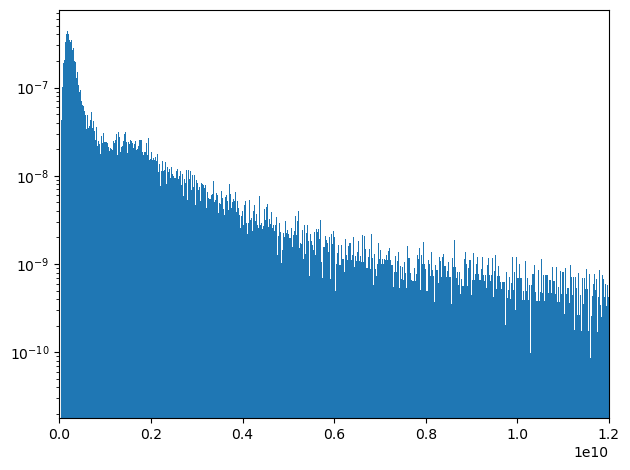

In [67]:
plt.hist(10.**(fuzz_age),weights=10.**(-fuzz_age),bins=8000)
#plt.ylim(0.,0.01)
plt.yscale('log')
plt.xlim(0,1.2e10)
plt.show()

In [ ]:
object_index = 46182
i = 23
DM = 18.45
# We want: 'logTe','logg','MH','Gmag','G_BPmag','G_RPmag', 'Jmag','Hmag','Ksmag'
obs0 = np.array([lmc['TEFF'][i],lmc['LOGG'][i],lmc['FE_H'][i],
                 lmc['G'][i]-DM,lmc['BP'][i]-DM,lmc['RP'][i]-DM,
                 lmc['J'][i]-DM,lmc['H'][i]-DM,lmc['K'][i]-DM])
std0 = np.array([lmc['TEFF_ERR'][i],lmc['LOGG_ERR'][i],lmc['FE_H_ERR'][i],
                 lmc['G_ERR'][i],lmc['BP_ERR'][i],lmc['RP_ERR'][i],
                 lmc['J_ERR'][i],lmc['H_ERR'][i],lmc['K_ERR'][i]])
print(obs0,std0)
obs = np.array([iso_pred[col][object_index] for col in iso_pred.colnames if col != 'index'])  #40080
std = np.array([100.,0.2,0.1,0.1,0.1,0.1,0.1,0.1,0.1])

obs_noised = obs + np.random.normal(0, var, obs.shape)
#print(obs_noised)

start_wall = time.time()

#chi2s,indx = chi2_for_one_object(obs_noised,var,iso_pred)
chi2s,indx = chi2_for_one_object(obs0,std0,iso_pred)

end_wall = time.time()
print('The age/mass estimate for this object took ',int(1000.*(end_wall - start_wall)),' milli-seconds ')

print('The best chi2 is', np.min(chi2s), ', which is at age ',iso_in['logAge'][indx[np.argmin(chi2s)]] )
print('The presumed mass of the star is',iso_in['Mini'][indx[np.argmin(chi2s)]])
print('The presumed reddening is',iso_in['Av'][indx[np.argmin(chi2s)]])

In [ ]:
ages = iso_in['logAge'][indx]
plt.scatter(ages,chi2s,c=iso_in['Av'][indx],cmap='rainbow')
plt.ylim(0.7*np.min(chi2s),10.*np.min(chi2s))
plt.yscale('log')
plt.colorbar(label='A_V')

print('input age was ',iso_in['logAge'][object_index])

In [ ]:
plt.hist(chi2s,bins=100,range=(0.,1000.))
plt.show()

Now train a nearest neighbour finder that for each input triplet ('MH', 'logAge','Mini') returns the row index, that has the nearest neighbour

This operates on gthe table iso_in

Just a quick plot to look at color vs Teff

In [ ]:
# this eyballing results in a simplified function call G-W1 = f(teff)
def gw1_0(Teff):
    return 1.3 - (Teff-5000)/2900 + np.exp((4500-Teff)/1400.)  + 0.03*np.exp((3700-Teff)/20.)

In [ ]:
Teff = iso_pred['Teff']
cc = iso_pred['Gmag']-iso_pred['Ksmag']
plt.scatter(Teff,cc - gw1_0(Teff), alpha=0.05,s=1)
#plt.scatter(Teff,cc - 1.3 + (Teff-5000)/2900 - np.exp((4500-Teff)/1400.)  - 0.03*np.exp((3700-Teff)/20.), alpha=0.05,s=1)
plt.ylim(-0.5,0.5)
plt.xlim(3500.,7500.)
#plt.colorbar(label='Minit')
plt.gca().invert_xaxis()
plt.show()


In [ ]:
# Initialize the NearestNeighbors class
# You can specify the algorithm to use ('auto', 'ball_tree', 'kd_tree', or 'brute')
nn = NearestNeighbors(n_neighbors=1, algorithm='auto')

# Fit the model to your data
nn.fit(iso_in)
print('finished training the NearestNeighbour fitting')


In [ ]:
MH = -1.43
logAge = 8.03
M = []
X = []
Y = []
for Minit in np.arange(0.5, 5.1, 0.001):
    point = np.array([[MH, logAge, Minit]])
    distances, index = nn.kneighbors(point)
    M.append(Minit)
    X.append(10.**iso_pred[index[0],1])
    Y.append(iso_pred[index[0],2])
    #print(index,point,iso_pred[index[0],3])
    
plt.scatter(X,Y,c=M,cmap='viridis')
plt.ylim(0.,5.)
plt.xlim(4000.,7500.)
plt.colorbar(label='Minit')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()


In [ ]:
# let's find the N nearest neighbours
nn8 = NearestNeighbors(n_neighbors=8, algorithm='auto')
nn8.fit(iso_in)
print('finished training the NearestNeighbour fitting')

In [ ]:

# Function to find and print the nearest neighbor
def find_nearest_neighbor(test_point):  
    start_wall = time.time()
    distances, indices = nn8.kneighbors(test_point)
    end_wall = time.time()
    wall_time = end_wall - start_wall
    
    print(f"The nearest point to {test_point} is at index {indices[0][:]} with a distance of {distances[0][:]}")
    print(f"The coordinates of the nearest point are {test_points[indices[0][:]]}")
    print(f"Wall-clock time taken: {wall_time} seconds")

# Find the nearest neighbor to an initial test point
initial_test_point = np.array([iso_in[7,:]])
find_nearest_neighbor(initial_test_point)

# Find the nearest neighbor to a new test point
#new_test_point = np.array([[0.4, 0.5, 0.6]])
#find_nearest_neighbor(new_test_point)
